In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# progress bar for pandas
from tqdm.notebook import tqdm
tqdm.pandas()

### Read labels & Images

In [4]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [5]:
EPOCHS = 20
SAMPLE_LEN = 1821
IMAGE_PATH = "images/"

In [6]:
def load_image(image_id):
    file_path = image_id + ".jpg"
    image = cv2.imread(IMAGE_PATH + file_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

train_images = train_data["image_id"][:SAMPLE_LEN].progress_apply(load_image)

In [7]:
test_images = test_data["image_id"][:SAMPLE_LEN].progress_apply(load_image)

#### Covert labels to label encoding

In [8]:
encoded_labels = train_data[['healthy', 'multiple_diseases', 'rust', 'scab']]
# rust = 3, scab = 4, healthy = 1, multiple_diseases = 2

In [9]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
labels = [[1],[2],[3],[4]]
encoder = enc.fit(labels)
decoded_labels = encoder.inverse_transform(encoded_labels)

### Preprocessing

#### Resizing (interpolation method, inter area)

In [10]:
# inner area
img_size = 100
ptrain_images = []
for image in train_images:
    image=cv2.resize(image,(img_size,img_size),interpolation=cv2.INTER_AREA)
    ptrain_images.append(image)

In [11]:
# inner area
ptest_images = []
for image in test_images:
    image=cv2.resize(image,(img_size,img_size),interpolation=cv2.INTER_AREA)
    ptest_images.append(image)

#### Vectorizing all channels

In [12]:
X_train = np.ndarray(shape=(len(ptrain_images), img_size*img_size*3), dtype=np.float32)
for i, image in enumerate(ptrain_images):
    X_train[i,] = image.reshape(img_size*img_size*3)
X_train.shape    

(1821, 30000)

In [13]:
X_test = np.ndarray(shape=(len(ptest_images), img_size*img_size*3), dtype=np.float32)
for i, image in enumerate(ptest_images):
    X_test[i,] = image.reshape(img_size*img_size*3)
X_test.shape    

(1821, 30000)

#### Extracing and vectorizing blue channel

In [14]:
blue_train = [(ptrain_images[idx][:,:,2].reshape(img_size**2)) for idx in range(len(ptrain_images))]
blue_train = np.array(blue_train)
blue_train.shape

(1821, 10000)

In [15]:
blue_test = [(ptest_images[idx][:,:,2].reshape(img_size**2)) for idx in range(len(ptest_images))]
blue_test = np.array(blue_test)
blue_test.shape

(1821, 10000)

#### Histogram-of-oriented-gradients (HoG)
Reference: https://www.learnopencv.com/histogram-of-oriented-gradients/

To determine the size, ideally we want the resulting vector to be the same or smaller than the baseline case, which is dimension 100 x 100 with only the blue channel. (A vector of 10000 for each image).

Assuming we still want cubic pictures the number of 16 by 16 pixel cube allowed along each axis is $\sqrt{10000/4/9} = 17.7 $
The number of pixels along each axis is $17\times8+8 = 144$

This means we can take in a 136 * 136 * 3 rgb image and transform it into a d = 9216 vector with this HoG method.

Trial \#2 takes 200 * 200 * 3 rgb image and transform it into a d = 20736 vector.

#### Visualizing Gradient

In [16]:
# visualizing 1 image with Hog
def grad_img(idx, img_size, label):
    plt.rcParams['figure.figsize'] = [16, 4]
    im = train_images[idx]
    im = cv2.resize(im,(img_size,img_size),interpolation=cv2.INTER_AREA)
    fig = plt.figure()
    plt.subplot(1,5,1)
    plt.title(label)
    plt.imshow(im)
    im_grad = np.float32(im) / 255.0
    gx = cv2.Sobel(im_grad, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(im_grad, cv2.CV_32F, 0, 1, ksize=1)
    mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
    plt.subplot(1,5,2)
    plt.title('All channels')
    plt.imshow(mag)
    plt.subplot(1,5,3)
    plt.title('Green channel')
    plt.imshow(mag[:,:,0])
    plt.subplot(1,5,4)
    plt.imshow(mag[:,:,1])
    plt.title('Red channel')
    plt.subplot(1,5,5)
    plt.imshow(mag[:,:,2])
    plt.title('Blue channel')
    plt.show()

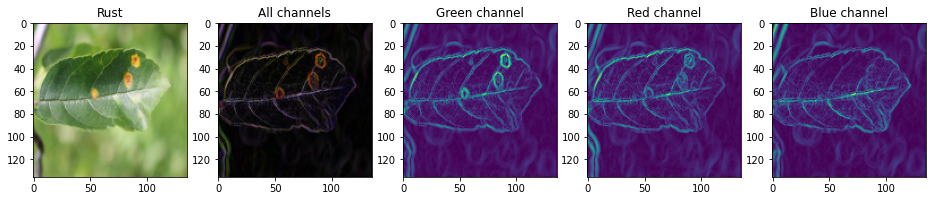

In [17]:
grad_img(3, 136, 'Rust')

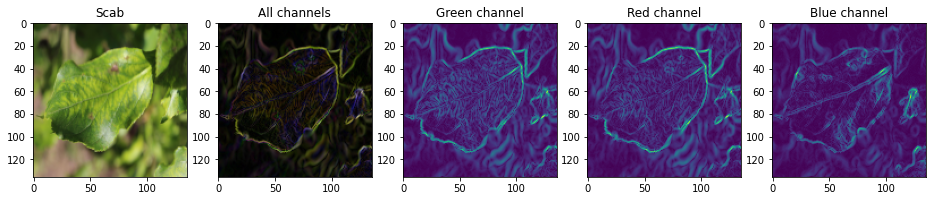

In [18]:
grad_img(0, 136, 'Scab')

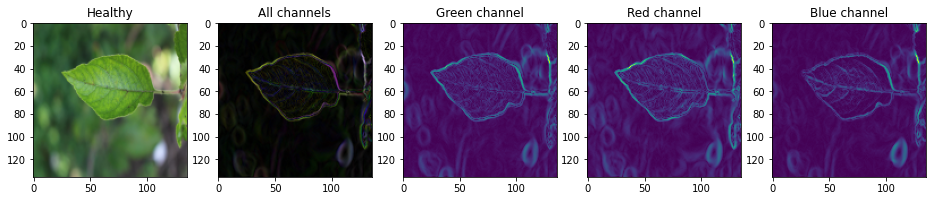

In [19]:
grad_img(9, 136, 'Healthy')

#### HOG augmentation

In [20]:
### initialize hog
winSize = (16,16)
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9
# derivAperture = 1
# winSigma = 4.
# histogramNormType = 0
# L2HysThreshold = 2.0000000000000001e-01
# gammaCorrection = 0
# nlevels = 64
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)
winStride = (8,8)
# padding = (8,8)
# locations = ((10,20),)
# hist = hog.compute(im1,winStride) #,padding,locations)

In [21]:
# train 
hog_tr = [hog.compute(cv2.resize(im,(136,136),interpolation=cv2.INTER_AREA),winStride).reshape(9216) for im in train_images]

In [22]:
hog_tr2 = [hog.compute(cv2.resize(im,(200,200),interpolation=cv2.INTER_AREA),winStride).reshape(20736) for im in train_images]

In [23]:
# test
hog_te = [hog.compute(cv2.resize(im,(136,136),interpolation=cv2.INTER_AREA),winStride).reshape(9216) for im in test_images]

In [24]:
hog_te2 = [hog.compute(cv2.resize(im,(200,200),interpolation=cv2.INTER_AREA),winStride).reshape(20736) for im in test_images]

#### Oversampling (synthetic new samples)

In [25]:
from imblearn.over_sampling import SMOTE 

Using TensorFlow backend.


In [26]:
# for training data with all 3 channels
y_train = decoded_labels.ravel()
sm = SMOTE(random_state = 0) 
X_train, y_train = sm.fit_resample(X_train,y_train)
X_train.shape,y_train.shape

((2488, 30000), (2488,))

In [27]:
# for training data with only the blue channel 
y_tr_blue = decoded_labels.ravel()
sm_blue = SMOTE(random_state = 0) 
blue_train, y_tr_blue = sm_blue.fit_resample(blue_train, y_tr_blue)
blue_train.shape, y_tr_blue.shape

((2488, 10000), (2488,))

In [28]:
# for training data preprocess with HOG (smaller dimension)
y_tr_hog = decoded_labels.ravel()
sm_hog = SMOTE(random_state = 0) 
hog_tr, y_tr_hog = sm_hog.fit_resample(hog_tr, y_tr_hog)
hog_tr.shape, y_tr_hog.shape

((2488, 9216), (2488,))

In [29]:
# for training data preprocess with HOG (larger dimension)
y_tr_hog2 = decoded_labels.ravel()
hog_tr2, y_tr_hog2 = sm_hog.fit_resample(hog_tr2, y_tr_hog2)
hog_tr2.shape, y_tr_hog2.shape

((2488, 20736), (2488,))

In [30]:
# inspect composition of labels after oversampling
unique, counts = np.unique(y_train, return_counts=True)
print (np.asarray((unique, counts)).T)

[[  1. 622.]
 [  2. 622.]
 [  3. 622.]
 [  4. 622.]]


### Random Forest (all channels) Kaggle Score = 0.54727

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

#### Model building and hyperparameter tuning

In [32]:
# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

In [33]:
# CV with Grid Search
# parameters = {
#     'n_estimators' : [100, 150, 200],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth': [10, 50, 100, 200, 500]    
# }
parameters = {
    'n_estimators' : [50, 100],
    'max_features': ['sqrt'],
    'max_depth': [10, 50, 100]    
}
Grid_RF = GridSearchCV(RandomForestClassifier(oob_score=True), parameters, cv=5)
Grid_RF.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=True, random_state=None,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={

In [34]:
print_grid_search_metrics(Grid_RF)

Best score: 0.6382636655948553
Best parameters set:
max_depth:50
max_features:sqrt
n_estimators:100


#### Prediction for test

In [35]:
# predict and output csv files for submission
RF_pred = Grid_RF.predict(X_test)
labels = pd.get_dummies(RF_pred)
labels.columns=['healthy', 'multiple_diseases', 'rust', 'scab']
RF_result = test_data.join(labels)
RF_result.to_csv("RF_result.csv", index=False)

In [37]:
unique, counts = np.unique(RF_pred, return_counts=True)
print (np.asarray((unique, counts)).T)

[[  1. 546.]
 [  2.  40.]
 [  3. 560.]
 [  4. 675.]]


### Random Forest (blue channel only)  Kagge score = 0.53429

In [38]:
# CV with Grid Search
parameters = {
    'n_estimators' : [50, 100],
    'max_features': ['sqrt'],
    'max_depth': [10, 50, 100]    
}
Grid_RFb = GridSearchCV(RandomForestClassifier(oob_score=True), parameters, cv=5)
Grid_RFb.fit(blue_train, y_tr_blue)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=True, random_state=None,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={

In [39]:
# display accuracy and best hyperparameters
print_grid_search_metrics(Grid_RFb)

Best score: 0.5418006430868167
Best parameters set:
max_depth:100
max_features:sqrt
n_estimators:100


In [40]:
# predict and output csv files for submission
RFb_pred = Grid_RFb.predict(blue_test)
labels = pd.get_dummies(RFb_pred)
labels.columns=['healthy', 'multiple_diseases', 'rust', 'scab']
RFb_result = test_data.join(labels)
RFb_result.to_csv("RFb_result.csv", index=False)

### Random Forest with Hog (vec_len 9216) Kaggle score = 0.55419

In [41]:
# CV with Grid Search
parameters = {
    'n_estimators' : [50, 100],
    'max_features': ['sqrt'],
    'max_depth': [10, 50, 100]    
}
Grid_RFhog = GridSearchCV(RandomForestClassifier(oob_score=True), parameters, cv=5)
Grid_RFhog.fit(hog_tr, y_tr_hog)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=True, random_state=None,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={

In [42]:
# display accuracy and best hyperparameters
print_grid_search_metrics(Grid_RFhog)

Best score: 0.6310289389067524
Best parameters set:
max_depth:50
max_features:sqrt
n_estimators:100


In [43]:
# predict and output csv files for submission
RFhog_pred = Grid_RFhog.predict(hog_te)
labels = pd.get_dummies(RFhog_pred)
labels.columns=['healthy', 'multiple_diseases', 'rust', 'scab']
RFhog_result = test_data.join(labels)
RFhog_result.to_csv("RFhog_result.csv", index=False)

### Random Forest with HOG (vec_len 20736) Kagge score = 0.54156

In [44]:
# CV with Grid Search
parameters = {
    'n_estimators' : [50, 100],
    'max_features': ['sqrt'],
    'max_depth': [10, 50, 100]    
}
Grid_RFhog2 = GridSearchCV(RandomForestClassifier(oob_score=True), parameters, cv=5)
Grid_RFhog2.fit(hog_tr2, y_tr_hog2)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=True, random_state=None,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={

In [45]:
# display accuracy and best hyperparameters
print_grid_search_metrics(Grid_RFhog2)

Best score: 0.6302250803858521
Best parameters set:
max_depth:50
max_features:sqrt
n_estimators:100


In [46]:
# predict and output csv files for submission
RFhog_pred2 = Grid_RFhog2.predict(hog_te2)
labels = pd.get_dummies(RFhog_pred2)
labels.columns=['healthy', 'multiple_diseases', 'rust', 'scab']
RFhog_result2 = test_data.join(labels)
RFhog_result2.to_csv("RFhog_result2.csv", index=False)

### Evaluation of the best RF model (HOG with small dimension input)

In [47]:
from sklearn import model_selection
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import f1_score

In [48]:
X_tr, X_holdout, y_tr, y_holdout = model_selection.train_test_split(hog_tr, y_tr_hog, test_size=0.25, random_state=1)

In [49]:
best_RF = RandomForestClassifier(max_depth=10, n_estimators=100, max_features='sqrt', random_state=0, oob_score=True)
best_RF.fit(X_tr, y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [50]:
rf_probs = best_RF.predict_proba(X_holdout)
y_hat = best_RF.predict(X_holdout)
conf_matrix = confusion_matrix(y_holdout, y_hat)
keys=['healthy', 'multiple_diseases', 'rust', 'scab']
conf_df = pd.DataFrame(conf_matrix, index=keys, columns=keys)
# print('confusion matrix:\n', conf_matrix)
conf_df

,healthy,multiple_diseases,rust,scab
healthy,80,1,35,34
multiple_diseases,3,154,2,5
rust,45,1,67,55
scab,28,1,27,84


In [51]:
y_holdout_dummy = pd.get_dummies(y_holdout).values
y_hat = pd.get_dummies(y_hat).values
fpr, tpr = dict(), dict()
precision, recall = dict(), dict()
auc_score, f1 = dict(), dict()
for i in range(4):
    fpr[keys[i]], tpr[keys[i]], _ = roc_curve(y_holdout_dummy[:, i], rf_probs[:, i])
    precision[keys[i]], recall[keys[i]], _ = precision_recall_curve(y_holdout_dummy[:, i], rf_probs[:, i])
    auc_score[keys[i]] = np.round(auc(fpr[keys[i]], tpr[keys[i]]),4)
    f1[keys[i]] = np.round(f1_score(y_holdout_dummy[:, i], y_hat[:, i]),4)
print('auc:\n',auc_score)
print('f1_score\n', f1)

auc:
 {'healthy': 0.8144, 'multiple_diseases': 0.9917, 'rust': 0.7652, 'scab': 0.7926}
f1_score
 {'healthy': 0.5229, 'multiple_diseases': 0.9595, 'rust': 0.4482, 'scab': 0.5283}


In [53]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

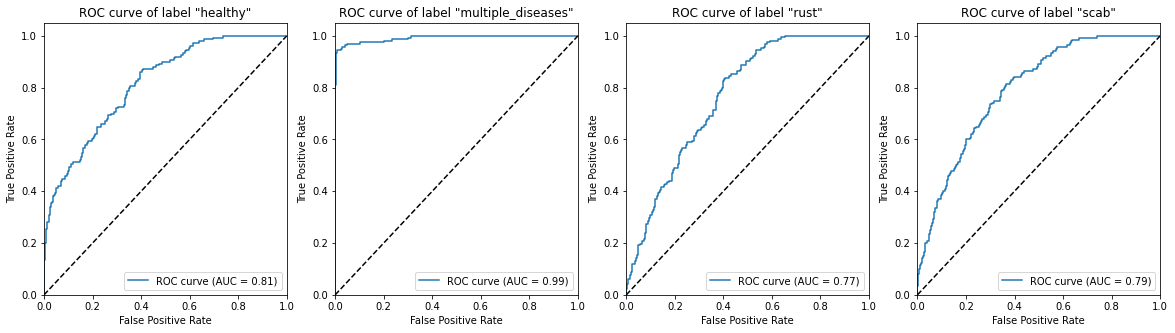

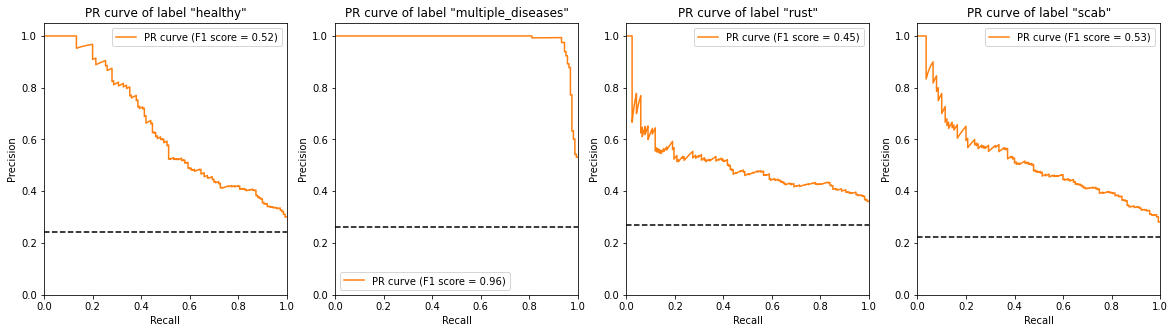

In [54]:
plt.rcParams['figure.figsize'] = [20, 5]

for i in range(4):
    plt.subplot(1,4,i+1)
    plt.plot(fpr[keys[i]], tpr[keys[i]], label='ROC curve (AUC = %0.2f)' % auc_score[keys[i]])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('''ROC curve of label "%s"''' %keys[i])
    plt.legend(loc="best")
plt.show()

for i in range(4):
    plt.subplot(1,4,i+1)
    no_skill = len(y_holdout[y_holdout==i+1]) / len(y_holdout)
    plt.plot([0, 1], [no_skill, no_skill], 'k--')
    plt.plot(recall[keys[i]], precision[keys[i]], color = 'C1', label='PR curve (F1 score = %0.2f)' % f1[keys[i]])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('''PR curve of label "%s"''' %keys[i])
    plt.legend(loc="best")
plt.show()

---